# Goals of this script

1. Import the rMATS parsed data for all skipped exons only
2. Apply a series of cutoffs
3. Randomly select a subset of the chosen events and obtain rMATS2sashimiplot screenshots
4. Then go through visually and score the events showing visible change in PSI, marginal change, or no visible change

# Variable cutoffs to use
1. FDR
2. dPSI
3. Junction Reads
4. Gene Expression - FPKM from cuffdiff
5. Require no more than 1 variable exon between skipping junction
6. rMATS cstat value


In [5]:
#Import a bunch of the usual packages
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import matplotlib.ticker as ticker
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as stats
import copy
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)

# Function for venn diagram and dPSI overlap

In [17]:
#Function for intersecting rMATS data
#Get a sense of the overlap
def two_sample_splicing_venn_and_shared_delta_psi_delta_psi(filtered_sample_1,sample_1_name,filtered_sample_2,sample_2_name,splice_or_variable):
    "This will make the venn diagram comparing all splicing events and then take the shared events and plot the delta psi"

    def get_set(dataframe,splice_or_variable):
        if splice_or_variable == 'splice':
            splice_set = set(dataframe.splice_id.tolist())
        elif splice_or_variable == 'variable':
            splice_set = set(dataframe.v_id.tolist())
        return splice_set
    sample_1_splice_set = get_set(filtered_sample_1,splice_or_variable)
    sample_2_splice_set = get_set(filtered_sample_2,splice_or_variable)

#     if contingency == 'yes':
#         sample_1_splice_set = get_set(sample_1_df,splice_or_variable)

    #Using the sets, find the intersection splice id
    intersection = list(sample_1_splice_set.intersection(sample_2_splice_set))

    #Also find the differences between the two
    sample_1_only = list(sample_1_splice_set.difference(sample_2_splice_set))
    sample_2_only = list(sample_2_splice_set.difference(sample_1_splice_set))

    #collect the parts of the dataframe that meet the intersection set
    sample_1_intersection = filtered_sample_1.loc[filtered_sample_1.v_id.isin(intersection)]
    sample_2_intersection = filtered_sample_2.loc[filtered_sample_2.v_id.isin(intersection)]

    #collect the parts from sample only and assume a delta psi of 0 for the other sets. Add a dummy inc level difference to account for this
    sample_1_only_df = filtered_sample_1.loc[filtered_sample_1.v_id.isin(sample_1_only)]
    sample_1_only_df['IncLevelDummy'] = 0

    sample_2_only_df = filtered_sample_2.loc[filtered_sample_2.v_id.isin(sample_2_only)]
    sample_2_only_df['IncLevelDummy'] = 0

    #Critical - sort by splice ID for the intersection ones
    sample_1_intersection.sort_values(by='splice_id',inplace=True)
    sample_2_intersection.sort_values(by='splice_id',inplace=True)

    #put into lists for easier access
    sample_1_intersection_psi = sample_1_intersection.IncLevelDifference.tolist()
    sample_2_intersection_psi = sample_2_intersection.IncLevelDifference.tolist()

    #make venn of splicing events and shared figure
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
    fig.subplots_adjust(wspace=3)

    #relabel venn with percentages of what they have on their own and then the shared as a value
    sample_1_percent =str(len(sample_1_splice_set.difference(sample_2_splice_set)))+'\n'+str(round(float(len(sample_1_splice_set.difference(sample_2_splice_set))/float(len(sample_1_splice_set)))*100,1))+'%'
    sample_2_percent =str(len(sample_2_splice_set.difference(sample_1_splice_set)))+'\n'+str(round(float(len(sample_2_splice_set.difference(sample_1_splice_set))/float(len(sample_2_splice_set)))*100,1))+'%'
    sample_1_and_2_shared = len(intersection)

    relabel_list = [sample_1_percent,sample_2_percent,sample_1_and_2_shared]

    #relabel function
    def reformat_labels_to_my_taste(v):
        counter = 0
        for sl in v.subset_labels:
            if sl is not None:
                sl.set_text(str(relabel_list[counter]))
            counter += 1

    #venn
    venn = mplv.venn2([sample_1_splice_set,sample_2_splice_set],set_labels=[sample_1_name,sample_2_name],ax=ax1,set_colors=['b','r'])
    #ax1.set_title('Differential spliced cassettes')

    reformat_labels_to_my_taste(venn)

    #scatter plot
    ax2.scatter(x=sample_1_intersection.IncLevelDifference,y=sample_2_intersection.IncLevelDifference,c='brown')
#     ax2.scatter(x=sample_1_only_df.IncLevelDifference,y=sample_1_only_df.IncLevelDummy,c='red')
#     ax2.scatter(x=sample_2_only_df.IncLevelDummy,y=sample_2_only_df.IncLevelDifference,c='green')

    ax2.set_ylim(top=1,bottom=-1)
    ax2.set_xlim(left=-1,right=1)
    ax2.set_xlabel(sample_1_name+' dPSI INC <--> SKIP')
    ax2.set_ylabel(sample_2_name+' dPSI INC <--> SKIP')
    #add lines on origin
    plt.axhline(0,color='black',alpha=0.6)
    plt.axvline(0,color='black',alpha=0.6)

    #add a y=x line
    lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
        ]

    # now plot both limits against eachother
    #ax2.plot(lims, lims, 'k-', alpha=0.2, zorder=0)
#     ax2.plot(lims,lims,'k-', alpha=0.2, zorder=0)
    ax2.set_aspect('equal')
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)

    x = sample_1_intersection.IncLevelDifference.reset_index(drop=True)
    y = sample_2_intersection.IncLevelDifference.reset_index(drop=True)

    #add fit line
    if len(x) > 0:
        m, b = np.polyfit(x,y,1)
        #with limits as points in plot
        plt.plot(x, m*x + b,'-',color = 'black')


    plt.tight_layout()
#         plt.show()
#     fig.savefig('pictures/'+sample_1_name+'_'+sample_2_name)

    #calculate the hypergeometric test for venn diagram
    #What is the population for sampling your differential test? How many alternative exons are tested?
    #Assume 70000 pulled from rMATS on average - this is the number of differential events tested? Might be too high...
    #Need to verify - is this correct? Check with Anna
    pop = 70000
    hyperp = stats.hypergeom.sf(len(sample_1_intersection),pop,len(sample_1_intersection)+len(sample_1_only_df),len(sample_1_intersection)+len(sample_2_only_df))
#         print(p)

    #Also calculate the "discordance ratio" = different direction / all direction
    #get the number positive and negative
    #positive dpsi = factor promotes skipping
    #negative dpsi = factor promotes inclusion

    #calc lengths, not useful
    #sample_1_pos = float(len(sample_1_intersection[sample_1_intersection.IncLevelDifference > 0]))
    #sample_1_neg = float(len(sample_1_intersection[sample_1_intersection.IncLevelDifference < 0]))
    #sample_2_pos = float(len(sample_2_intersection[sample_2_intersection.IncLevelDifference > 0]))
    #sample_2_neg = float(len(sample_2_intersection[sample_2_intersection.IncLevelDifference < 0]))

    #separate into pos,pos:pos,neg:neg,pos:neg:neg

    pos_pos = 0.0
    pos_neg = 0.0
    neg_pos = 0.0
    neg_neg = 0.0
    for i in range(len(sample_1_intersection_psi)):
        if sample_1_intersection_psi[i] > 0:
            if sample_2_intersection_psi[i] > 0:
                pos_pos += 1
            else:
                pos_neg += 1
        else:
            if sample_2_intersection_psi[i] > 0:
                neg_pos += 1
            else:
                neg_neg += 1

    #calculate a discordant ratio
    #need to account for non overlaps
    if len(sample_1_intersection) > 0:
        discord = (pos_neg + neg_pos) / (pos_pos+pos_neg+neg_pos+neg_neg)
        concord = (pos_pos + neg_neg) / (pos_pos+pos_neg+neg_pos+neg_neg)
    else:
        discord = 0
        concord = 0
    #print(round(concord,2)*100,'percent concordant')

    #Is it possible to plot pearson and spearman correlations here
    pearson_corr,pearson_p = stats.pearsonr(sample_1_intersection.IncLevelDifference.tolist(),sample_2_intersection.IncLevelDifference.tolist())
    print(pearson_corr,'pearson_correlation_coefficient')
    spearman_corr,spearman_p = stats.spearmanr(sample_1_intersection.IncLevelDifference.tolist(),sample_2_intersection.IncLevelDifference.tolist())
    print(spearman_corr,'spearman_correlation_coefficient')
    
    return(intersection)

# Master function for validation

In [6]:
#Master Function for validation
def master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi):
    
    test_df = pd.read_table(rmats_parsing_file)
    
    print(len(test_df),'number_of_SE_events')
    
    def test_filter(df,reads,fdr,dpsi,flip_needed):
        df = df[df.SAMPLE_1_mean_total > reads]
        df = df[df.SAMPLE_2_mean_total > reads]
        #now need to generate variable ID and filter based on highest junction read
        df['v_id'] = df.splice_id.str.split(':').str[1] + ':' + df.splice_id.str.split(':').str[2] + ':' + df.splice_id.str.split(':').str[5] + ":" + df.splice_id.str.split(':').str[6] + ":" + df.GeneID
        #make a combo_junctions column that adds up the junctions contributing to the splicing event from both sample groups
        df['combo_junctions'] = df.SAMPLE_1_mean_total + df. SAMPLE_2_mean_total
        #sort based on these junctions with the highest first
        df.sort_values(by='combo_junctions',ascending=False,inplace=True)
        #drop duplicates keeping the highest based on variable ID
        df.drop_duplicates(subset='v_id',keep='first',inplace=True)
        #fdr filter
        df = df[df.FDR <= fdr]
        #dpsi filter
        df = df[df.IncLevelDifference.abs() >= dpsi]
        #the flip part is yes if you need to flip the deltaPSI to make positive deltaPSI = promote skipping and negative deltaPSI to promote inclusion
        if flip_needed == 'yes':
            df['IncLevelDifference'] = df.IncLevelDifference * -1    
        return(df)

    filt_df = test_filter(test_df,reads,fdr,dpsi,flip_needed)
    
    print(len(filt_df),'number_of_SE_events_post_reads_fdr_dpsi')
    
    gene_df = pd.read_table(cuffdiff_file)
    gene_df['GeneID'] = gene_df.gene_id.str.split('.').str[0]

    #Merge splice and gene
    splice_gene_merge = filt_df.merge(gene_df,on='GeneID')
    
    #filt by FPKM
    splice_gene_filt = splice_gene_merge[(splice_gene_merge.value_1 > fpkm)|(splice_gene_merge.value_2 > fpkm)]
    
    print(len(splice_gene_filt),'number_of_SE_events_post_FPKM')
    
    #Acquire bed file with collapsed exons from gencode_v24 basic
    gencode_v24 = pbt.BedTool('../annotations/gencode_extracted_regions/prepare_collapsed_exons/gencode.v24lift37.basic_exons.final_collapse.bed')

    def filter_out_events_with_intervening_exons(df,exon_bed):
        #Get the intron bed
        bed_df = df[['chr','upstreamEE','downstreamES','splice_id','IncLevelDifference','strand']]
        bed_bt = pbt.BedTool.from_dataframe(bed_df)
        #get the exon bed
        exon_bed = pbt.BedTool(exon_bed)
        #Get the number of whole overlap intersections per event
        intersect = bed_bt.intersect(exon_bed,c=True,s=True,F=1)
        intersect_names = bed_bt.intersect(exon_bed,wao=True,s=True,F=1)
        #make into df
        cols = ['chr','upstreamEE','downstreamES','splice_id','IncLevelDifference','strand','num_intersect']
        intersect_df = intersect.to_dataframe(names=cols)
        cols = ['chr','upstreamEE','downstreamES','splice_id','IncLevelDifference','strand','a','b','c','d','e','f','g']
        intersect_names_df = intersect_names.to_dataframe(names=cols)
        #collect the ones with only one overlap
        one_overlap = intersect_df[intersect_df.num_intersect == 1]
        return(intersect_df,intersect_names_df,one_overlap)

    if one_variable_only == 'yes':
        intersect_df,intersect_names_df,one_overlap = filter_out_events_with_intervening_exons(splice_gene_filt,gencode_v24)
        print(len(one_overlap),'number_of_SE_events_with_one_V_exon')
    else:
        one_overlap = splice_gene_filt
    
    def run_rmats2sashimiplot(select_df,orig_df,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed):
        cols = ['ID','GeneID','geneSymbol','chr','strand','exonStart_0base','exonEnd','upstreamES','upstreamEE','downstreamES','downstreamEE','ID','IJC_SAMPLE_1','SJC_SAMPLE_1','IJC_SAMPLE_2','SJC_SAMPLE_2','IncFormLen','SkipFormLen','PValue','FDR','IncLevel1','IncLevel2','IncLevelDifference']
        full_df = orig_df[orig_df.splice_id.isin(select_df.splice_id)]
        os.system('mkdir RMATS_VALIDATION/{}'.format(df_name))
        
        #save the full df
        full_df.to_csv('RMATS_VALIDATION/'+df_name+'/'+df_name+'.rmats_filt.full.txt',sep='\t',index=False)
        
        #Take a sample of these events to make rMATS2SashimiPlot for visual validation
        df = full_df.sample(frac=sample_frac,random_state=sample_seed)
        df.to_csv('RMATS_VALIDATION/'+df_name+'/'+df_name+'.rmats_filt.sample.txt',sep='\t',index=False)
        
        fn = 'RMATS_VALIDATION/'+df_name+'/'+df_name+'.rmats_filt.sample.txt'
        
        if run_sashimi == 'yes':
            cmd = 'rmats2sashimiplot --b1 {} --b2 {} -t SE -e {} --l1 {} --l2 {} --exon_s {} --intron_s {} -o {}'.format(bam1_list,bam2_list,fn,label1,label2,exon_scale,intron_scale,'RMATS_VALIDATION/'+df_name)
            os.system(cmd)    
        
    run_rmats2sashimiplot(one_overlap,filt_df,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed)

# Running HTE samples different cutoffs

## Different rMATS inputs to use
### hte_turbo_loose = rMATS-turbo with cstat = 0.0001, gencode v24 basic
### hte_turbo_strict = rMATS-turbo with cstat = 0.05, gencode v24 basic
### hte_turbo_tsl1 = rMATS-turbo with cstat = 0.05, gencode v25 TSL1 only
### hte_turbo_original = rMATS-turbo with cstat = 0.0001, gencode v24 comprehensive, older version of STAR
### hte_orig_whippet = rMATS-turbo with cstat = 0.0001, gencode v24 comprehensive, older version of STAR, overlap with signficantly regulated exons from another tool Whippet

# Running with standard cutoffs, but changing inputs

In [60]:
#hte_turbo_loose - only one variable only
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.15
reads = 10
fpkm = 5
flip_needed = 'yes'
one_variable_only = 'yes'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_run1'
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(528, 'number_of_SE_events_post_reads_fdr_dpsi')
(349, 'number_of_SE_events_post_FPKM')
(168, 'number_of_SE_events_with_one_V_exon')


In [ ]:
#hte_turbo_loose - any number of variable exons

In [62]:
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.15
reads = 10
fpkm = 5
flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'


exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_run1_complex'
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(528, 'number_of_SE_events_post_reads_fdr_dpsi')
(349, 'number_of_SE_events_post_FPKM')


In [63]:
#hte_turbo_original - any number of variable exons
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_original_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.15
reads = 10
fpkm = 5
flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'


exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_run1_original'
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(76188, 'number_of_SE_events')
(780, 'number_of_SE_events_post_reads_fdr_dpsi')
(528, 'number_of_SE_events_post_FPKM')


In [64]:
#hte_turbo_strict, any number of variable exons
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_strict_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.15
reads = 10
fpkm = 5
flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'


exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_strict'
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(263, 'number_of_SE_events_post_reads_fdr_dpsi')
(210, 'number_of_SE_events_post_FPKM')


In [79]:
#Intersection of hte_turbo_loose complex and whippet
rmats_parsing_file = '../../../systematic_analysis_of_sam_data/hte_new_complex_rmats_whippet_intersection.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.15
reads = 10
fpkm = 5
flip_needed = 'no'
one_variable_only = 'no'
run_sashimi = 'no'


exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_whippet_intersection_new'
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(172, 'number_of_SE_events')
(172, 'number_of_SE_events_post_reads_fdr_dpsi')
(172, 'number_of_SE_events_post_FPKM')


In [80]:
#with TSL1 and c = 0.0001
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_tsl1_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.15
reads = 10
fpkm = 5
flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_run1_tsl1'
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(47450, 'number_of_SE_events')
(347, 'number_of_SE_events_post_reads_fdr_dpsi')
(241, 'number_of_SE_events_post_FPKM')


# Testing different cutoffs

## Changes in dPSI

In [7]:
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.1
reads = 10
fpkm = 5
cutoff_string = '_'.join([str(fdr),str(dpsi),str(reads),str(fpkm)])

flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_loose_'+cutoff_string
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
dpsi = 0.15
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
dpsi = 0.2
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(577, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(528, 'number_of_SE_events_post_reads_fdr_dpsi')
(349, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(321, 'number_of_SE_events_post_reads_fdr_dpsi')
(188, 'number_of_SE_events_post_FPKM')


## Changes in FDR

In [8]:
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.1
dpsi = 0.1
reads = 10
fpkm = 5
cutoff_string = '_'.join([str(fdr),str(dpsi),str(reads),str(fpkm)])

flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_loose_'+cutoff_string
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
fdr = 0.05
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
fdr = 0.01
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(938, 'number_of_SE_events_post_reads_fdr_dpsi')
(652, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(577, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(609, 'number_of_SE_events_post_reads_fdr_dpsi')
(476, 'number_of_SE_events_post_FPKM')


## Changes in Junction Reads

In [10]:
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.1
dpsi = 0.1
reads = 10
fpkm = 5
cutoff_string = '_'.join([str(fdr),str(dpsi),str(reads),str(fpkm)])

flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_loose_'+cutoff_string
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
reads = 20
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
reads = 40
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(938, 'number_of_SE_events_post_reads_fdr_dpsi')
(652, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(840, 'number_of_SE_events_post_reads_fdr_dpsi')
(634, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(712, 'number_of_SE_events_post_reads_fdr_dpsi')
(599, 'number_of_SE_events_post_FPKM')


## Changes in FPKM

In [11]:
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.1
reads = 10
fpkm = 3
cutoff_string = '_'.join([str(fdr),str(dpsi),str(reads),str(fpkm)])

flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_loose_'+cutoff_string
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
fpkm = 5
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
fpkm = 10
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)

(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(666, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(577, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(412, 'number_of_SE_events_post_FPKM')


## Excluding events with more than one variable exon (complex) or not

In [12]:
#One Variable
rmats_parsing_file = 'rMATS_parsing_turbo/hte_turbo_loose_all_SE_FDR_1.0_dPSI_0.0_read_cutoff_0.0.txt'
cuffdiff_file = '../cuffdiff_runs/HTE_cuffdiff/gene_exp.diff'

fdr = 0.05
dpsi = 0.1
reads = 10
fpkm = 5
cutoff_string = '_'.join([str(fdr),str(dpsi),str(reads),str(fpkm)])

flip_needed = 'yes'
one_variable_only = 'no'
run_sashimi = 'no'

exon_scale = 1
intron_scale = 4
sample_frac = 0.1
sample_seed = 10

bam1_list = '../star_runs/HTE1Aligned.sortedByCoord.out.bam,../star_runs/HTE3Aligned.sortedByCoord.out.bam'
bam2_list = '../star_runs/HTE2Aligned.sortedByCoord.out.bam,../star_runs/HTE4Aligned.sortedByCoord.out.bam'
df_name = 'HTE_loose_'+cutoff_string
label1 = 'HTE_WT'
label2 = 'HTE_KD'

master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)
print('\n')
one_variable_only = 'yes'
master_rmats_validation(rmats_parsing_file,cuffdiff_file,df_name,bam1_list,bam2_list,label1,label2,exon_scale,intron_scale,sample_frac,sample_seed,flip_needed,fdr,dpsi,reads,one_variable_only,run_sashimi)


(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(577, 'number_of_SE_events_post_FPKM')


(58079, 'number_of_SE_events')
(809, 'number_of_SE_events_post_reads_fdr_dpsi')
(577, 'number_of_SE_events_post_FPKM')
(298, 'number_of_SE_events_with_one_V_exon')


In [81]:
#How well do these groups overlap?
# how well do the improvements compare to the original?
#Overlap between the three best groups
hte_original = pd.read_table('RMATS_VALIDATION/HTE_run1_original/HTE_run1_original.rmats_filt.full.txt')
hte_with_complex = pd.read_table('RMATS_VALIDATION/HTE_run1_complex/HTE_run1_complex.rmats_filt.full.txt')
hte_no_complex = pd.read_table('RMATS_VALIDATION/HTE_run1/HTE_run1.rmats_filt.full.txt')
hte_intersect_new = pd.read_table('RMATS_VALIDATION/HTE_whippet_intersection_new/HTE_whippet_intersection_new.rmats_filt.full.txt')
hte_strict = pd.read_table('RMATS_VALIDATION/HTE_strict/HTE_strict.rmats_filt.full.txt')
hte_tsl1 = pd.read_table('RMATS_VALIDATION/HTE_run1_tsl1/HTE_run1_tsl1.rmats_filt.full.txt')

(0.9991188746220574, 'pearson_correlation_coefficient')
(0.99990163869927018, 'spearman_correlation_coefficient')


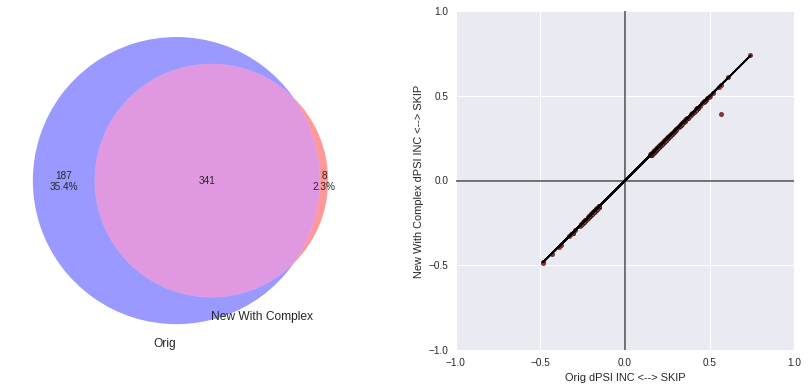

In [72]:
#Original and New With Complex
intersection = two_sample_splicing_venn_and_shared_delta_psi_delta_psi(hte_original,'Orig',hte_with_complex,'New With Complex','variable')

(0.99805630969774084, 'pearson_correlation_coefficient')
(0.99996064536356477, 'spearman_correlation_coefficient')


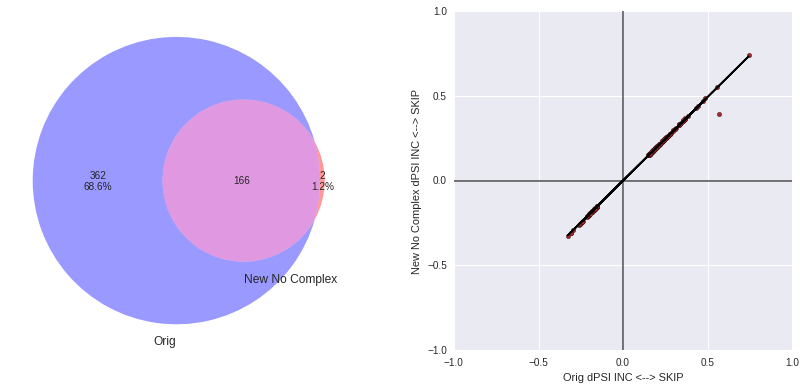

In [73]:
#Original and New No Complex
intersection = two_sample_splicing_venn_and_shared_delta_psi_delta_psi(hte_original,'Orig',hte_no_complex,'New No Complex','variable')

(1.0, 'pearson_correlation_coefficient')
(1.0, 'spearman_correlation_coefficient')


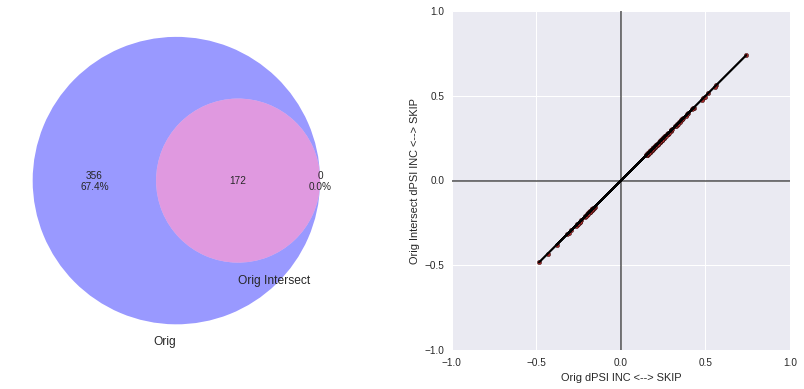

In [75]:
#Original and New Whippet Intersection
intersection = two_sample_splicing_venn_and_shared_delta_psi_delta_psi(hte_original,'Orig',hte_intersect_new,'Orig Intersect','variable')

(0.99873067205809507, 'pearson_correlation_coefficient')
(0.99963193006671258, 'spearman_correlation_coefficient')


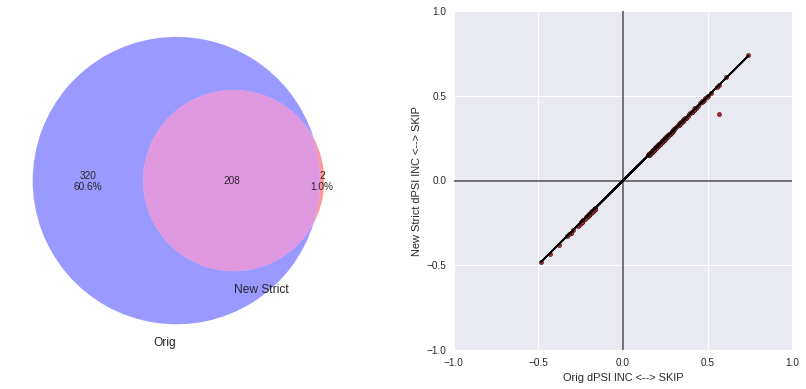

In [76]:
#Original and New Strict Cutoff
intersection = two_sample_splicing_venn_and_shared_delta_psi_delta_psi(hte_original,'Orig',hte_strict,'New Strict','variable')

(0.99721148442922092, 'pearson_correlation_coefficient')
(0.99516872487925101, 'spearman_correlation_coefficient')


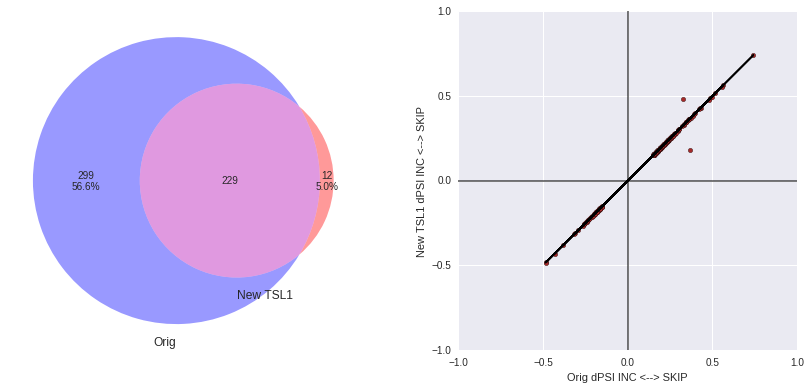

In [82]:
#Original and TSL1
intersection = two_sample_splicing_venn_and_shared_delta_psi_delta_psi(hte_original,'Orig',hte_tsl1,'New TSL1','variable')

<matplotlib_venn._common.VennDiagram instance at 0x7fb8d0528d88>

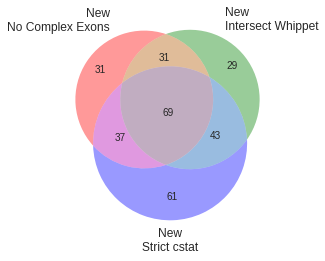

In [85]:
#Comparing No Complex, Intersection, STRICT

def make_set(df):
    the_set = set(df.v_id.tolist())
    return(the_set)

hte_no_complex_set = make_set(hte_no_complex)
hte_intersect_set = make_set(hte_intersect_new)
hte_strict_set = make_set(hte_strict)

mplv.venn3([hte_no_complex_set,hte_intersect_set,hte_strict_set],set_labels=['New\nNo Complex Exons','New\nIntersect Whippet','New\nStrict cstat'])

<matplotlib_venn._common.VennDiagram instance at 0x7fb8d0a7d170>

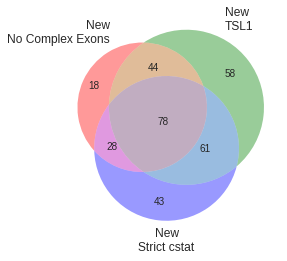

In [84]:
#Comparing No Complex, TSL1, STRICT
def make_set(df):
    the_set = set(df.v_id.tolist())
    return(the_set)

hte_no_complex_set = make_set(hte_no_complex)
hte_tsl1_set = make_set(hte_tsl1)
hte_strict_set = make_set(hte_strict)

mplv.venn3([hte_no_complex_set,hte_tsl1_set,hte_strict_set],set_labels=['New\nNo Complex Exons','New\nTSL1','New\nStrict cstat'])

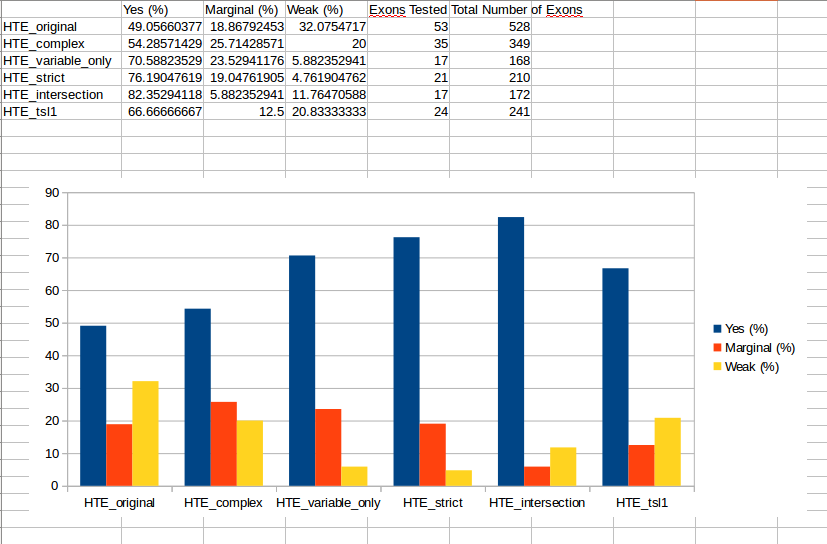

In [90]:
#Analysis from visual confirmation
from IPython.display import Image
Image(filename='/home/sam/Downloads/image.png')

# Conclusions
Three cutoffs that have best effect on reducing false positive rate
1. rMATS c value
2. Removing complex exons
3. Intersecting the data with another tool (Whippet)

However - they still have a substantial number of exon that don't overlap between the sets, which means the cutoffs seem to isolate different things

I think the best solution is to use the strict cutoff in rMATS, which seems to fix the problem without going through the issue of bringing online another tool